In this notebook, we implement a classifier to distinguish among different fruit species using their images as input data

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

## Data Loading and Preprocessing

In [43]:
#Load the dataset and transform into tensors
from torchvision import datasets, transforms

dataset_path=datasets.ImageFolder(root='fruits/Training/',
                                 transform=transforms.Compose(
                                     [transforms.ToTensor()]
                                 )
                                )

## Spliting dataset into train and test (80% training and 20% Test)

In [44]:
from torch.utils.data.sampler import SubsetRandomSampler

split = int(0.8* len(dataset_path))
index_list = list(range(len(dataset_path)))
np.random.shuffle(index_list)

train_idx, test_idx = index_list[:split], index_list[split:]

## create sample objects using SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

## create iterator objects for train and test datasets
train_loader = torch.utils.data.DataLoader(dataset_path, 
                                           batch_size = 256,
                                           sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset_path, 
                                           batch_size = 256,
                                           sampler=test_sampler)

print(f'Total Number of Examples: {len(dataset_path)}')
print(f'Number of training Examples: {len(train_sampler)}')
print(f'Number of testing Examples: {len(test_sampler)}')

Total Number of Examples: 8166
Number of training Examples: 6532
Number of testing Examples: 1634


In [45]:
Classes_num=len(train_loader.dataset.classes)
print(f'Number of Classes: {Classes_num}')
print(f'Classes Name: {train_loader.dataset.classes}')

Number of Classes: 15
Classes Name: ['Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Maroon', 'Walnut']


Example: 
(100, 100, 3)


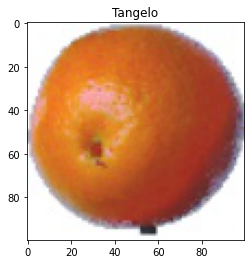

In [56]:
print("Example: ")
i1, l1 = next(iter(train_loader))
plt.title(train_loader.dataset.classes[l1[0]])
plt.imshow(np.array(i1[0].permute(1,2,0)));
print(np.array(i1[0].permute(1,2,0)).shape)

## Neural Network Model

Our model will be comprised of only one hidden layer which has extension of 128 neurons. They will receive data from input layer whose width is the flatten image (100 * 100 * 3). The image is enconded by RGB that why we have 3 values for each pixel in height x width map.

In [50]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100 * 100 * 3, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, Classes_num)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)
    
model = Model()
print(model)


Model(
  (fc1): Linear(in_features=30000, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=15, bias=True)
)


Define the loss function and the optimizer using the nn and optim package:

In [51]:
from torch import optim
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), 
                     lr = 0.01,
                     weight_decay = 1e-6,
                      momentum = 0.9,
                      nesterov = True)

## Model Training

In [52]:
epochs = 20
loss_array = []

for epoch in range(1, epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        # resize data from (batch_size, 100, 100, 3) 
        #             to (batch_size, 100*100*3)
        
        data = data.view(-1, 100*100*3)
        
        #set the gradients to zero 
        #before starting to do backpropragation
        optimizer.zero_grad() 
        
        ## 1. forward propagation
        model_out = model(data)
        
        ## 2. loss calculation
        loss = loss_function(model_out, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        loss_array.append(loss.item())
        if batch_idx % len(train_loader)-1 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 1, Loss: 2.6750824451446533
Epoch 2, Loss: 0.8485454320907593
Epoch 3, Loss: 0.18384511768817902
Epoch 4, Loss: 0.12313905358314514
Epoch 5, Loss: 0.05451619252562523
Epoch 6, Loss: 0.02978396601974964
Epoch 7, Loss: 0.027760308235883713
Epoch 8, Loss: 0.021740134805440903
Epoch 9, Loss: 0.014040283858776093
Epoch 10, Loss: 0.010360080748796463
Epoch 11, Loss: 0.007157284766435623
Epoch 12, Loss: 0.005474720150232315
Epoch 13, Loss: 0.008041895925998688
Epoch 14, Loss: 0.007147103548049927
Epoch 15, Loss: 0.005516473203897476
Epoch 16, Loss: 0.004727967083454132
Epoch 17, Loss: 0.0034713782370090485
Epoch 18, Loss: 0.003096196800470352
Epoch 19, Loss: 0.0028390511870384216


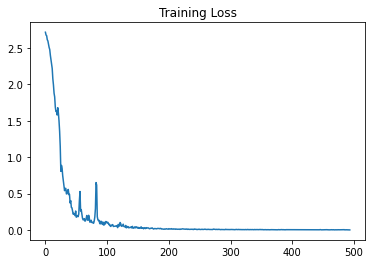

In [53]:
%matplotlib inline
plt.plot(loss_array)
plt.title("Training Loss")
plt.show()

## Model Testing

In [54]:
dataiter = iter(test_loader)
data, labels = dataiter.next()
data, target = Variable(data), Variable(target)
data_ = data.view(-1, 100*100*3)

output = model(data_)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())
print(f'Actual: {np.array(labels[:10])}')
print(f'Predicted: {preds[:10]}')

Actual: [12 11  4  3 10  4  4  5 14 10]
Predicted: [12 11  4  3 10  4  4  5 14 10]


In [55]:
correct = 0
test_loss = 0

for data, target in test_loader:
    data, target = Variable(data), Variable(target)
    data = data.view(-1, 100*100*3)
    net_out = model(data)
    
    test_loss += loss_function(net_out, target).item()
    pred = net_out.data.max(1)[1] #get index of the max log-probability
    correct += pred.eq(target.data).sum()
    
test_loss /= len(test_loader.dataset)

print(f'Average loss: {test_loss}')
print(f'Accuracy: {np.array(100.*correct / len(test_sampler))}%')
print(f'Total Test Examples: {len(test_sampler)}')
print(f'Correct predicted examples: {int(correct)}')

Average loss: 2.5260548111659887e-06
Accuracy: 100%
Total Test Examples: 1634
Correct predicted examples: 1634
